After having instilled on the dataset, it is time to leverage non-linear models and design the final solution. The scope of this Notebook:

1 - Definition of evaluation metric.   
2 - Benchmarking some algorithms.    
3 - Comprehensive evaluation.    
4 - SHAP values for interpretability.  

In [1]:
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
### Features
import pandas as pd
import numpy as np

data = pd.read_csv('data-cleaned.csv')

data['8'] = data['8'].astype(str)
data['12'] = data['12'].astype(str)
data['16'] = data['16'].astype(str)
data['20'] = data['20'].astype(str)

In [3]:
data.shape

(3300000, 29)

## Manifesto

In the "EDA" notebook, we have leveraged a logistic regression to assess some essential traits of the dataset, such as nonlinearity. Paths for nonlinearity are a MUST for us from now on. In the previous notebook, we assessed the model's quality by goodness-of-fit measures, such as AIC and BIC, and the loglikelihood. From now on, we evaluate through two `canonical` machine learning metrics: ROC Curve and Precision-Recall Curve. The fantastic Sebastian paper about model evaluation guides this benchmarking.  (https://arxiv.org/abs/1811.12808).  


------

### Warming up
To recap the paper of model: https://arxiv.org/pdf/1402.4735.pdf. In this project researchers from CA, USA, applied deep learning models to discriminate between signal and background noise, and soared the classification metric ROC on 0.08 points. On 500k simulated examples, DN achieved `0.88` of ROC AUC, combining low-level features, or the first 21 features, and the high-level features. remarkable. It's worthy mentioning the non-linearity awareness of researchers and their demand on creating new features, which matches thoroughly with our findings from statistical analysis.   
For deep details of features, access the article. Nevertheless, a simple description for it: 

```
The first 21 features represent basic measurements made by the particle detector, the momentum of each observed particle. These are the low-level features.   

Furthermore, the reserchers' knowledge about intemediate process allowed the construction of new features. They involve complex calculations with the previous 21 features. These are the high-level features.
```

----
### Methodology 

This notebook benchmarks some machine learning pipelines. Assuming the non-linearity, the list of candidate pipelines aims to overcome this challenge. The benchmark metric is ROC_AUC, calculated with Repeated Kfold resampling methodology(Trying to emulate a bootstrapping). Other metrics such as time for training, which stands for total time in seconds for the pipeline evaluation, and the total parameters model will be evaluated.  

A good predictive algorithm relies heavily on the ability of crafting new features from the low-level features, such for the last 8 features. I am not a specialist on Boson Higgs experiments, therefore I'll try some well-known techniques for feature engineering, by the book.

According to the article, the last seven features were created with the 21 features, based on some previous knowledge about the process. One great ideia for creating more new features would be trying to create new mathematical formula on top of the actual features by random attempts, perhaps with some optimization algorithm, such as genetic programming. For now, the best ideia comes from SVM and their kernels, where it creates new features by some calculations, such as polynomials and RBF. Scikit-learn has an amazing API to help us with this process. Nevertheless, some algorithms can learn non-linear patterns, such as neural networks, decision trees and the canonical ensembles(bagging, boosting). Recent benchmarkings revealed the Gradient Boosting implementation `xgboost` outperforming NN on tabular data: https://arxiv.org/pdf/2106.03253.pdf, so I will focus on the GB for this moment.

In [4]:
# Basic Imports
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import PolynomialCountSketch

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectFromModel

feature = data.columns.tolist()
feature.remove('target')
target = 'target'

categorical_low_level = ['8', '12', '16', '20']
low_level_features = ['0', '1', '2', '3', '4', '5', '6', '7', '9', '10', '11',  '13', '14', '15', '17', '18', '19']
high_level_features = ['21', '22', '23', '24', '25', '26', '28']

features = categorical_low_level+low_level_features+high_level_features

In [5]:
## Repeated K Fold Model evaluation.
def roc_sampling_kfold(model, 
                       n_splits=2, 
                       n_repetition=5, 
                       X=data[features], 
                       y=data[target]):
    
    cv_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repetition, random_state=42)
    return cross_validate(model, 
                    X, 
                    y, 
                    cv=cv_splitter,
                    return_train_score=True, 
                    scoring='roc_auc',
                    verbose=0)

1. Feature Pipelines Proposal

Time to get in on a cycle of creating features and evaluate them. At the end, try to filter the relevant features.    

To evaluate the predictive power of a dataset, I'll use two different algorithms: LogisticRegression, and DecisionTree. At the first moment, we will check whether adding polynomial and splines features increases the overall ROC.

In [6]:
categorical_transformer = OneHotEncoder(handle_unknown='infrequent_if_exist')
poly_transformer = PolynomialFeatures()
splinesampler = SplineTransformer()

# simple linear preprocessor
linear_preprocessor = make_column_transformer(
    (categorical_transformer, categorical_low_level),
    remainder='passthrough'
)

# polynomial preprocessor
poly_preprocessor = make_column_transformer(
    (categorical_transformer, categorical_low_level),
    (poly_transformer, low_level_features+high_level_features),
    remainder='passthrough'
)

# spline preprocessor
spline_preprocessor = make_column_transformer(
    (categorical_transformer, categorical_low_level),
    (splinesampler, low_level_features+high_level_features),
    remainder='passthrough'
)

# all of them combined
full_preprocessor = make_column_transformer(
    (categorical_transformer, categorical_low_level),
    (splinesampler, low_level_features+high_level_features),
    (poly_transformer, low_level_features+high_level_features),
    remainder='passthrough'
)


linear_model = SGDClassifier(loss='log_loss', penalty='l1')
dt = DecisionTreeClassifier(max_depth=11)

preprocessor_candidates = {'linear_preprocessor': linear_preprocessor,
                           'poly_preprocessor': poly_preprocessor,
                           'spline_preprocessor': spline_preprocessor,
                           'full_preprocessor': full_preprocessor}

The code snippet below evaluates the logistic with different approaches for feature engineering. The average ROC on 2-fold crossvalidation repeated 3 times outlines the improvement of the feature pipeline upgrade. 

In [9]:
for key_preprocessor in preprocessor_candidates.keys():
    
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor_candidates[key_preprocessor]),
                                  ('mdl', linear_model)])

    results_dict = roc_sampling_kfold(mdl_pipeline, n_repetition=3)
    print('avg roc_auc logistic regression ' +  str(key_preprocessor) + '(.25, .5, .75):', round(np.quantile(results_dict['test_score'], 0.25), 3), round(np.quantile(results_dict['test_score'], 0.5), 3), round(np.quantile(results_dict['test_score'], 0.75), 3) )
    print('--')

avg roc_auc logistic regression linear_preprocessor(.25, .5, .75): 0.667 0.667 0.668
--
avg roc_auc logistic regression poly_preprocessor(.25, .5, .75): 0.74 0.741 0.742
--
avg roc_auc logistic regression spline_preprocessor(.25, .5, .75): 0.749 0.75 0.751
--
avg roc_auc logistic regression full_preprocessor(.25, .5, .75): 0.759 0.76 0.76
--


The polynomial features have improved the model's results.   

Perhaps the simplest nonlinear model available is the decision tree, the model assessed in the following code snippet. DTs are prone to overfitting and need to be hyper-parameterized. By controlling the maximum size of a tree, we might ensure a good balance between over and underfitting. 

In [10]:
results_dt_depthness = []
for key_preprocessor in preprocessor_candidates.keys():
    print('-----------')
    for depth in range(5, 15):
        mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor_candidates[key_preprocessor]),
                                        ('mdl', DecisionTreeClassifier(max_depth=depth))])

        results_dict = roc_sampling_kfold(mdl_pipeline, n_repetition=3)

        print('avg roc_auc decision tree ' +  str(key_preprocessor) + 
              ' max depth: ' + str(depth) + 
              ' (.25, .5, .75):', 
              round(np.quantile(results_dict['test_score'], 0.25), 3), 
              round(np.quantile(results_dict['test_score'], 0.5), 3), 
              round(np.quantile(results_dict['test_score'], 0.75), 3) )
        
        results_dt_depthness.append({'max_depth': depth, 
                                     'preprocessor': key_preprocessor, 
                                     'median_roc_kfold': round(np.quantile(results_dict['test_score'], 0.25), 3)
                                    })
        print('--')

-----------
avg roc_auc decision tree linear_preprocessor max depth: 5 (.25, .5, .75): 0.724 0.726 0.727
--
avg roc_auc decision tree linear_preprocessor max depth: 6 (.25, .5, .75): 0.737 0.738 0.738
--
avg roc_auc decision tree linear_preprocessor max depth: 7 (.25, .5, .75): 0.749 0.75 0.75
--
avg roc_auc decision tree linear_preprocessor max depth: 8 (.25, .5, .75): 0.757 0.757 0.758
--
avg roc_auc decision tree linear_preprocessor max depth: 9 (.25, .5, .75): 0.762 0.762 0.764
--
avg roc_auc decision tree linear_preprocessor max depth: 10 (.25, .5, .75): 0.764 0.765 0.766
--
avg roc_auc decision tree linear_preprocessor max depth: 11 (.25, .5, .75): 0.764 0.764 0.765
--
avg roc_auc decision tree linear_preprocessor max depth: 12 (.25, .5, .75): 0.76 0.761 0.761
--
avg roc_auc decision tree linear_preprocessor max depth: 13 (.25, .5, .75): 0.752 0.753 0.753
--
avg roc_auc decision tree linear_preprocessor max depth: 14 (.25, .5, .75): 0.741 0.741 0.742
--
-----------
avg roc_auc de

<AxesSubplot:xlabel='max_depth', ylabel='median_roc_kfold'>

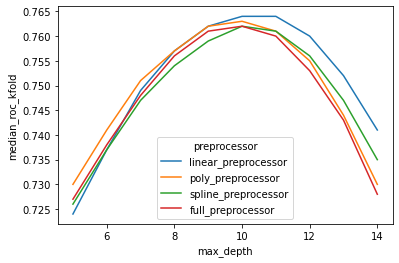

In [11]:
results_dt_depthness_df = pd.DataFrame(results_dt_depthness)
sns.lineplot(x='max_depth', y='median_roc_kfold', hue='preprocessor', data=results_dt_depthness_df)

It looks like polynomial features have not helped DT on the classification task. The nonlinear model has achieved 0.76 roc validation on max_depth 9, similar to the ROC achieved with the full preprocessor and LogisticRegression. The report below presents the difference in probability scores between both algorithms on a hold-out philosophy. Let's call the probability differences `delta_scores`.

In [12]:
from sklearn.model_selection import train_test_split

# simple holdout 
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data['target'], 
                                                    test_size=0.5, 
                                                    random_state=42)

dt_simple_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor),
                                        ('mdl', DecisionTreeClassifier(max_depth=9))])

logistic_pipeline = Pipeline(steps=[('preprocessor', full_preprocessor),
                                  ('mdl', linear_model)])

dt_simple_pipe.fit(X_train, y_train)
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['8', '12', '16', '20']),
                                                 ('splinetransformer',
                                                  SplineTransformer(),
                                                  ['0', '1', '2', '3', '4', '5',
                                                   '6', '7', '9', '10', '11',
                                                   '13', '14', '15', '17', '18',
                                                   '19', '21', '22', '23', '24',
                                                   '25', '26', '28']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  ['0', '1', '2', '3', '4', '5',
                                                   '6', '7', '9', '10', '11',
                                                   '13', '14', '15', '17', '18',
                                                   '19', '21', '22', '23', '24',
                                                   '25', '26', '28'])])),
                ('mdl', SGDClassifier(loss='log_loss', penalty='l1'))])

-0.08116610042566011 ,  0.030006678243958307 ,  0.14221022402107536


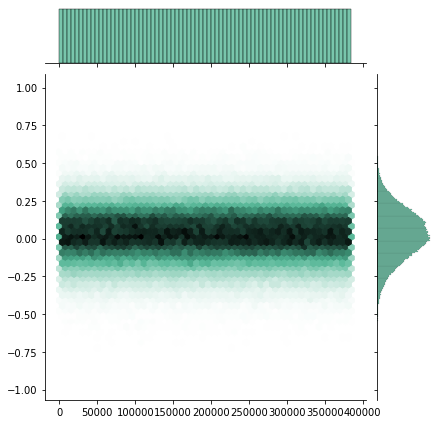

In [13]:
residuals = dt_simple_pipe.predict_proba(X_test)[:,1] - logistic_pipeline.predict_proba(X_test)[:,1]
print(np.quantile(residuals, 0.25), ', ', np.quantile(residuals, 0.5),  ', ', np.quantile(residuals, 0.75)) 
sns.jointplot(list(range(X_test.shape[0])), residuals, kind="hex", color="#4CB391")

50% of delta_scores fell into the range [-0.08, 0.14]. Despite the similar results on ROC cross-validation, the algorithms are notably different. Combining learners is an excellent way to improve the models' quality.

#### 2. Real Candidate models and Hyperparameter optimization

----
Gradient Boosting framework is state of the art for tabular data. Two of the best implementations for GB are XGboost and LGBMClassifier. As it follows, this notebook presents three sections: A model fitting with default parameters, a snippet for hyperparameter search, and the final results for each GB model.

Default Model Fitting

In [7]:
xgb_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                           ('mdl', XGBClassifier(max_depth=9, 
                                                 tree_method='hist'))])

results_dict = roc_sampling_kfold(xgb_pipe, n_repetition=2, n_splits=5)
print('avg roc_auc with top on test (.25, .5, .75): ', round(np.quantile(results_dict['test_score'], 0.25), 3), round(np.quantile(results_dict['test_score'], 0.5), 3), round(np.quantile(results_dict['test_score'], 0.75), 3) )
print('avg roc_auc with top on train (.25, .5, .75): ', round(np.quantile(results_dict['train_score'], 0.25), 3), round(np.quantile(results_dict['train_score'], 0.5), 3), round(np.quantile(results_dict['train_score'], 0.75), 3) )

avg roc_auc with top on test (.25, .5, .75):  0.834 0.834 0.834
avg roc_auc with top on train (.25, .5, .75):  0.86 0.86 0.86


Default Parameters achieved remarkable results. Let's optimize the hyperparameters of both algorithms.

In [8]:
lgbm_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', LGBMClassifier(max_depth=10))])

results_dict = roc_sampling_kfold(lgbm_pipe, n_repetition=2, n_splits=5)
print('avg roc_auc with top on test (.25, .5, .75): ', round(np.quantile(results_dict['test_score'], 0.25), 3), round(np.quantile(results_dict['test_score'], 0.5), 3), round(np.quantile(results_dict['test_score'], 0.75), 3) )
print('avg roc_auc with top on train (.25, .5, .75): ', round(np.quantile(results_dict['train_score'], 0.25), 3), round(np.quantile(results_dict['train_score'], 0.5), 3), round(np.quantile(results_dict['train_score'], 0.75), 3) )

avg roc_auc with top on test (.25, .5, .75):  0.812 0.812 0.812
avg roc_auc with top on train (.25, .5, .75):  0.813 0.813 0.813


In [161]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

lgbm_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', LGBMClassifier())])

### successive halving, hyperparameter analysis
param_grid = {
                'mdl__max_depth': [10, 13, 15],
                'mdl__learning_rate': [0.15, 0.2, 0.25],
                'mdl__num_leaves': [100, 150, 200],
                'mdl__min_child_samples': [5, 10, 15, 20],
                'mdl__subsample': [0.8, 0.9],
                'mdl__reg_alpha': [0.05, 0.1, 0.2, 0.3],
                'mdl__reg_lambda': [0.05, 0.1, 0.2, 0.3],
              }

sh = HalvingGridSearchCV(lgbm_pipe, 
                         param_grid, 
                         cv=2, 
                         factor=3, 
                         min_resources=50000, 
                         verbose=1,
                         scoring='roc_auc',
                         refit=False
                        ).fit(data[features], data[target])

lgbm_results = pd.DataFrame(sh.cv_results_)

n_iterations: 2
n_required_iterations: 8
n_possible_iterations: 2
min_resources_: 50000
max_resources_: 330000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3456
n_resources: 50000
Fitting 2 folds for each of 3456 candidates, totalling 6912 fits
----------
iter: 1
n_candidates: 1152
n_resources: 150000
Fitting 2 folds for each of 1152 candidates, totalling 2304 fits
CPU times: total: 1d 12h 50min 30s
Wall time: 3h 21min 15s


In [166]:
lgbm_results.sort_values('mean_test_score', ascending=False)[0:5][['params', 
                                                                   'mean_fit_time']].values

array([[{'mdl__learning_rate': 0.15, 'mdl__max_depth': 13, 'mdl__min_child_samples': 15, 'mdl__num_leaves': 100, 'mdl__reg_alpha': 0.3, 'mdl__reg_lambda': 0.3, 'mdl__subsample': 0.8},
        1.0621819496154785],
       [{'mdl__learning_rate': 0.15, 'mdl__max_depth': 13, 'mdl__min_child_samples': 15, 'mdl__num_leaves': 100, 'mdl__reg_alpha': 0.3, 'mdl__reg_lambda': 0.3, 'mdl__subsample': 0.9},
        1.0805635452270508],
       [{'mdl__learning_rate': 0.15, 'mdl__max_depth': 10, 'mdl__min_child_samples': 20, 'mdl__num_leaves': 100, 'mdl__reg_alpha': 0.2, 'mdl__reg_lambda': 0.3, 'mdl__subsample': 0.9},
        1.014492392539978],
       [{'mdl__learning_rate': 0.15, 'mdl__max_depth': 10, 'mdl__min_child_samples': 20, 'mdl__num_leaves': 100, 'mdl__reg_alpha': 0.2, 'mdl__reg_lambda': 0.3, 'mdl__subsample': 0.8},
        1.0224412679672241],
       [{'mdl__learning_rate': 0.15, 'mdl__max_depth': 13, 'mdl__min_child_samples': 20, 'mdl__num_leaves': 100, 'mdl__reg_alpha': 0.2, 'mdl__reg_lam

In [163]:
%%time
xgb_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', XGBClassifier())])

param_grid = { 'mdl__tree_method': ['hist'],
               'mdl__subsample': [0.8, 0.9, 1], 
               'mdl__learning_rate': [0.05, 0.1, 0.15, 0.2],
               'mdl__reg_alpha': [15, 20, 30, 40],
               'mdl__reg_lambda': [15, 25, 35, 45],
               'mdl__max_depth': [10, 13, 15, 18],
              }

sh = HalvingGridSearchCV(xgb_pipe, 
                         param_grid, 
                         cv=2, 
                         factor=2, 
                         min_resources=20000, 
                         verbose=1,
                         scoring='roc_auc',
                         refit=False
                        ).fit(data[features], data[target])

xgb_results = pd.DataFrame(sh.cv_results_).sort_values('mean_test_score', ascending=False)

n_iterations: 5
n_required_iterations: 10
n_possible_iterations: 5
min_resources_: 20000
max_resources_: 330000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 768
n_resources: 20000
Fitting 2 folds for each of 768 candidates, totalling 1536 fits
----------
iter: 1
n_candidates: 384
n_resources: 40000
Fitting 2 folds for each of 384 candidates, totalling 768 fits
----------
iter: 2
n_candidates: 192
n_resources: 80000
Fitting 2 folds for each of 192 candidates, totalling 384 fits
----------
iter: 3
n_candidates: 96
n_resources: 160000
Fitting 2 folds for each of 96 candidates, totalling 192 fits
----------
iter: 4
n_candidates: 48
n_resources: 320000
Fitting 2 folds for each of 48 candidates, totalling 96 fits
CPU times: total: 16h 45min 28s
Wall time: 1h 31min


In [ ]:
xgb_results.sort_values('mean_test_score', ascending=False)[0:5][['params', 
                                                                   'mean_fit_time']].values

Amazing!  The optimal hyperparameters training

In [8]:
optimal_parameter_xgb = {'learning_rate': 0.15,
                         'max_depth': 10,
                         'reg_alpha': 15,
                         'reg_lambda': 25,
                         'subsample': 1,
                         'tree_method': 'hist'}

optimal_parameter_lgbm = {'learning_rate': 0.15,
                         'max_depth': 13,
                         'min_child_samples': 15,
                         'num_leaves': 100,
                         'reg_alpha': 0.3,
                         'reg_lambda': 0.3,
                         'subsample': 0.8}


xgb_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', XGBClassifier(**optimal_parameter_xgb))])


lgbm_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', LGBMClassifier(**optimal_parameter_lgbm))])

data_roc_evaluation_xgb = roc_sampling_kfold(xgb_pipe, 
                                             n_splits=5, 
                                             n_repetition=2, 
                                             X=data[features], 
                                             y=data[target])
data_roc_evaluation_lgbm = roc_sampling_kfold(lgbm_pipe, 
                                              n_splits=5, 
                                              n_repetition=2, 
                                              X=data[features], 
                                              y=data[target])

<AxesSubplot:>

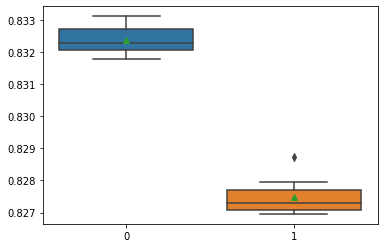

In [11]:
sns.boxplot(
    data=[data_roc_evaluation_xgb['test_score'], data_roc_evaluation_lgbm['test_score']],
    showmeans=True,
)

XGBoost has beaten LGBM on the optimal hyperparameters, performing `0.832` on ROC. 

---- 
Kaggle pratictioners know some important techniques for category encoding that can push XGboost overall results. The code snippet below benchmarks three ideias: MeanEncoder, WoEEncoder e PRatioEncoder. 

In [21]:
## benchmarking some new categorical encoding techniques.
from feature_engine.encoding import MeanEncoder, WoEEncoder, PRatioEncoder

dummy_encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
mean_encoder = MeanEncoder()
woe_encoder = WoEEncoder()
odd_encoder = PRatioEncoder()


dummy_preprocessor = make_column_transformer(
    (dummy_encoder, categorical_low_level),
    remainder='passthrough'
)

mean_preprocessor = make_column_transformer(
    (mean_encoder, categorical_low_level),
    remainder='passthrough'
)

woe_preprocessor = make_column_transformer(
    (woe_encoder, categorical_low_level),
    remainder='passthrough'
)

odd_preprocessor = make_column_transformer(
    (odd_encoder, categorical_low_level),
    remainder='passthrough'
)

dict_preprocessor = {'dummy_preprocessor': {'preprocessor':dummy_preprocessor},
                     'mean_preprocessor': {'preprocessor':mean_preprocessor},
                     'woe_preprocessor': {'preprocessor':woe_preprocessor},
                     'odd_preprocessor': {'preprocessor':odd_preprocessor}
                    }

for preprocessor in dict_preprocessor.keys():
    xgb_pipe = Pipeline(steps=[('preprocessor', dict_preprocessor[preprocessor]['preprocessor']), 
                            ('mdl', XGBClassifier(**optimal_parameter_xgb))])
    
    data_roc_evaluation_ = roc_sampling_kfold(xgb_pipe, 
                                              n_splits=5, 
                                              n_repetition=3, 
                                              X=data[features], 
                                              y=data[target])

    dict_preprocessor[preprocessor]['_results'] = data_roc_evaluation_

<AxesSubplot:>

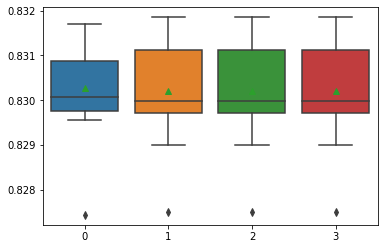

In [22]:
sns.boxplot(
    data=[dict_preprocessor['dummy_preprocessor']['_results']['test_score'],
          dict_preprocessor['mean_preprocessor']['_results']['test_score'],         
          dict_preprocessor['woe_preprocessor']['_results']['test_score'],
          dict_preprocessor['odd_preprocessor']['_results']['test_score']
        ],
    showmeans=True,
)

Categorical techniques don't improve results at all.

#### 3 - Comprehensive model evaluation

Learning Curve is a fabulous graphical way to grasp the influence of sample size on the convergence of cross-validation score and the similarity with the training score. Notwithstanding the exclusive relevance of CV score, having close results is critical for a consistent model.

In [9]:
xgb_pipe = Pipeline(steps=[('preprocessor', linear_preprocessor), 
                            ('mdl', XGBClassifier(**optimal_parameter_xgb))])

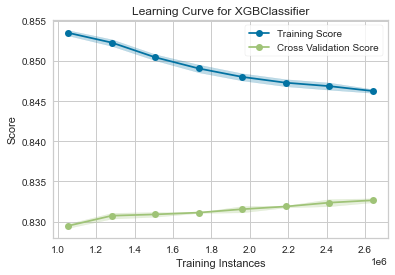

<AxesSubplot:title={'center':'Learning Curve for XGBClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [12]:
from sklearn.model_selection import KFold
from yellowbrick.model_selection import LearningCurve

cv = KFold(n_splits=5)
sizes = np.linspace(0.4, 1.0, 8)

visualizer = LearningCurve(
    xgb_pipe, cv=cv, scoring='roc_auc', train_sizes=sizes, n_jobs=2
)

visualizer.fit(data[features], data[target])      
visualizer.show()

The current 0.833 on ROC might improve with more data, as the steadily grown suggests. 

The graph DiscriminationThreshold crafts precision, recall, F1 and queue rate throughout every of thresholds. The later is out of scope for now, however is useful on many others activities, such as fraud prevention. The documentation: https://www.scikit-yb.org/en/latest/api/classifier/threshold.html#:~:text=The%20discrimination%20threshold%20is%20the,or%20to%20other%20application%20factors. 

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(xgb_pipe, n_jobs=2)

visualizer.fit(data[features], data[target])        
visualizer.show()        

The F1 score is harmonic mean between precision and recall, and the optimal value is at threshold 0.38.

----
The calibration curve is key to assessing how close the predict_proba is to a frequentist probability. As long as it converges, we can interpret the predict_proba by the meaningful trait of classical statistics. Sklearn has a valuable API for this. https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html

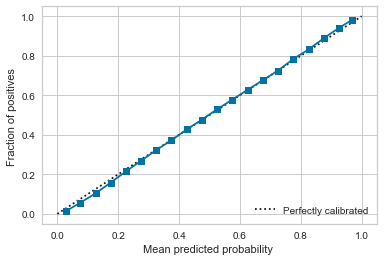

In [11]:
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve

#Holdout validation
X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[target], 
                                                    test_size=0.3, 
                                                    random_state=42)

xgb_pipe.fit(X_train, y_train) 
y_prob = xgb_pipe.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

The calibration is nearly perfect

#### 4 - Shap

----

Shap values is a technique for global interpretation based on aggregations of Shapley values.    
Shapley value is a technique for measuring feature importance by the average marginal contribution of each feature along all possible coalitions.

https://christophm.github.io/interpretable-ml-book/shap.html
https://christophm.github.io/interpretable-ml-book/shapley.html

In [31]:
import shap 

def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=features)
    return xgb_pipe.predict(data_asframe)

explainer = shap.KernelExplainer(model_predict, X_train[0:1000])
shap_values_f = explainer.shap_values(data[features].values[0:300,:])

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

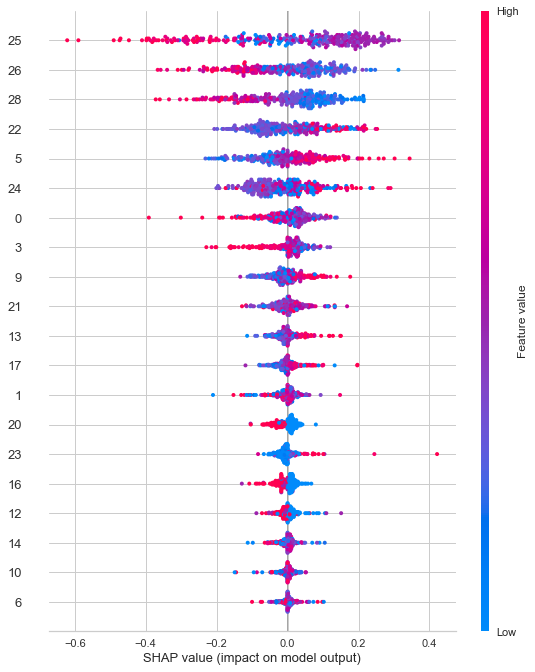

In [32]:
shap.initjs() 

shap.summary_plot(shap_values_f, data[features].values[0:300,:], feature_names=features)

Features 25, 26, 28, 22 and 5 are the most relevant for classes' dissimilarity

----
We are ready and set to deploy the ML model on the framework. The file README.md gives instructions on how to deploy it.

After deploying the model and triggering the pipeline, the results of final model might be analyzed with the support of notebook: `nbks/DEFAULT_log_analysis.ipynb`